In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import ast
from tqdm import tqdm

from src.etl.utils import download_data_from_uciml, load_data, preprocess_data
from src.models.training import (
    adam_factory, sgd_nesterov_factory, adagrad_factory, rmsprop_factory,
    LogisticRegression, SimpleNN, ComplexNN,
    perform_cross_validation, grid_search_optimizer, train_full_dataset
)
from src.models.charts import plot_optimizer_losses_for_models

In [2]:
from IPython.display import display, HTML
js = "<script>$('.output_scroll').removeClass('output_scroll')</script>"
display(HTML(js))

This notebook contains 3 sections : Data, K-Fold Cross Validation and Training with best hyper-paramters.

## Data

In [3]:
download_data_from_uciml(id=544)
X, y = load_data()
print(X.shape, y.shape)

(2111, 16) (2111,)


In [4]:
X.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
dtype: object

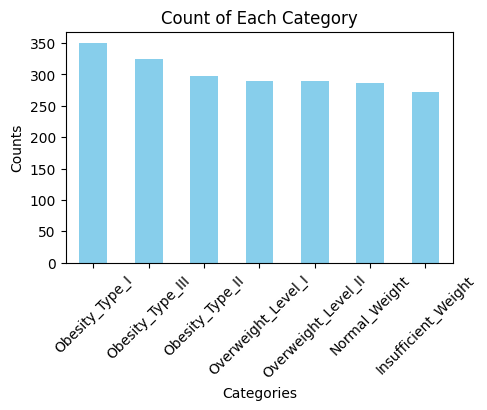

In [5]:
plot_df = y.value_counts()

plt.figure(figsize=(5, 3))
plot_df.plot(kind='bar', color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Count of Each Category')
plt.xticks(rotation=45)
plt.show()

In [6]:
[print(f"Missing data for {data}: \n {globals()[data].isna().sum()}") for data in ["y", "X"]]

Missing data for y: 
 0
Missing data for X: 
 Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64


[None, None]

In [7]:
X.shape

(2111, 16)

In [8]:
threshold = .01

X_filtered = X.copy()
y_filtered = y.copy()
for col in list(X_filtered.select_dtypes(include=['object']).columns):
    count_col = X_filtered[col].value_counts(normalize=True)
    print(count_col[count_col < .01])
    # Filter out rare classes
    rare_indices = X_filtered.index[X_filtered[col].isin(count_col[count_col < threshold].index)].tolist()
    X_filtered = X_filtered.drop(rare_indices)
    y_filtered = pd.Series([y_filtered[i] for i in range(len(y_filtered)) if i not in rare_indices])

Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
CALC
Always    0.000474
Name: proportion, dtype: float64
MTRANS
Motorbike    0.005213
Bike         0.003318
Name: proportion, dtype: float64


In [9]:
X_filtered.shape

(2092, 16)

## KFold Cross Validation
Within this section, we performed a 5-Fold Cross-Validation to get the best hyper-parameters for each model/optimizers. First, we have to define a grid over which we will search the best hyper-parameters:

In [11]:
adam_grid = {
    'lr': [0.001, 0.0005, 0.0001, 0.00005],
    'betas': [(0.9, 0.999), (0.95, 0.999), (0.85, 0.995)]
}

sgd_grid = {
    'lr': [0.01, 0.005, 0.001, 0.0005],
    'momentum': [0.95, 0.9, 0.8],
    'nesterov': [True]
}

adagrad_grid = {
    'lr': [0.01, 0.005, 0.001, 0.0005]
}

rmsprop_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'alpha': [0.99, 0.9],
    'momentum': [0.95, 0.9, 0.8]
}

Then, we instanciate our models and optimizers:

In [12]:
logistic_regression_factory = lambda input_size, output_size: LogisticRegression(input_size, output_size)
simple_nn_factory = lambda input_size, output_size: SimpleNN(input_size, output_size)
complex_nn_factory = lambda input_size, output_size: ComplexNN(input_size, output_size)

models = {
    'Logistic Regression': logistic_regression_factory,
    'Simple Neural Network': simple_nn_factory,
    'Complex Neural Network': complex_nn_factory
}

optimizers = {
    'Adam': (adam_factory, adam_grid),
    'SGD_Nesterov': (sgd_nesterov_factory, sgd_grid),
    'AdaGrad': (adagrad_factory, adagrad_grid),
    'RMSProp': (rmsprop_factory, rmsprop_grid)
}

Then, we can define and run our K-Folds CV loop:

  0%|          | 0/4 [00:00<?, ?it/s]


Running grid search for Logistic Regression with Adam
Fold 1, Accuracy: 78.04295942720763%
Fold 2, Accuracy: 74.22434367541766%
Fold 3, Accuracy: 76.07655502392345%
Fold 4, Accuracy: 76.79425837320574%
Fold 5, Accuracy: 80.622009569378%
Params: {'lr': 0.001, 'betas': (0.9, 0.999)}, Accuracy: 77.15%
Fold 1, Accuracy: 77.56563245823389%
Fold 2, Accuracy: 74.46300715990454%
Fold 3, Accuracy: 75.11961722488039%
Fold 4, Accuracy: 77.99043062200957%
Fold 5, Accuracy: 80.14354066985646%
Params: {'lr': 0.001, 'betas': (0.95, 0.999)}, Accuracy: 77.06%
Fold 1, Accuracy: 78.99761336515513%
Fold 2, Accuracy: 75.41766109785203%
Fold 3, Accuracy: 76.55502392344498%
Fold 4, Accuracy: 77.7511961722488%
Fold 5, Accuracy: 81.33971291866028%
Params: {'lr': 0.001, 'betas': (0.85, 0.995)}, Accuracy: 78.01%
Fold 1, Accuracy: 71.1217183770883%
Fold 2, Accuracy: 69.92840095465394%
Fold 3, Accuracy: 69.13875598086125%
Fold 4, Accuracy: 71.29186602870813%
Fold 5, Accuracy: 76.07655502392345%
Params: {'lr': 0.0

 25%|██▌       | 1/4 [02:07<06:22, 127.65s/it]

Fold 10, Accuracy: 81.81818181818181%
Average Cross-Validation Accuracy: 78.63%

Running grid search for Logistic Regression with SGD_Nesterov
Fold 1, Accuracy: 85.91885441527447%
Fold 2, Accuracy: 88.54415274463007%
Fold 3, Accuracy: 89.71291866028709%
Fold 4, Accuracy: 91.14832535885168%
Fold 5, Accuracy: 89.47368421052632%
Params: {'lr': 0.01, 'momentum': 0.95, 'nesterov': True}, Accuracy: 88.96%
Fold 1, Accuracy: 84.24821002386635%
Fold 2, Accuracy: 85.20286396181385%
Fold 3, Accuracy: 86.60287081339713%
Fold 4, Accuracy: 87.5598086124402%
Fold 5, Accuracy: 86.60287081339713%
Params: {'lr': 0.01, 'momentum': 0.9, 'nesterov': True}, Accuracy: 86.04%
Fold 1, Accuracy: 82.57756563245823%
Fold 2, Accuracy: 81.62291169451073%
Fold 3, Accuracy: 83.01435406698565%
Fold 4, Accuracy: 82.53588516746412%
Fold 5, Accuracy: 85.64593301435407%
Params: {'lr': 0.01, 'momentum': 0.8, 'nesterov': True}, Accuracy: 83.08%
Fold 1, Accuracy: 84.24821002386635%
Fold 2, Accuracy: 85.68019093078759%
Fold 3

 50%|█████     | 2/4 [04:02<04:00, 120.33s/it]

Fold 10, Accuracy: 89.95215311004785%
Average Cross-Validation Accuracy: 89.06%

Running grid search for Logistic Regression with AdaGrad
Fold 1, Accuracy: 67.5417661097852%
Fold 2, Accuracy: 65.87112171837708%
Fold 3, Accuracy: 65.55023923444976%
Fold 4, Accuracy: 65.55023923444976%
Fold 5, Accuracy: 69.377990430622%
Params: {'lr': 0.01}, Accuracy: 66.78%
Fold 1, Accuracy: 59.427207637231504%
Fold 2, Accuracy: 62.05250596658711%
Fold 3, Accuracy: 54.54545454545455%
Fold 4, Accuracy: 55.50239234449761%
Fold 5, Accuracy: 62.44019138755981%
Params: {'lr': 0.005}, Accuracy: 58.79%
Fold 1, Accuracy: 33.41288782816229%
Fold 2, Accuracy: 35.32219570405728%
Fold 3, Accuracy: 30.861244019138756%
Fold 4, Accuracy: 27.51196172248804%
Fold 5, Accuracy: 37.08133971291866%
Params: {'lr': 0.001}, Accuracy: 32.84%
Fold 1, Accuracy: 15.513126491646778%
Fold 2, Accuracy: 20.286396181384248%
Fold 3, Accuracy: 17.22488038277512%
Fold 4, Accuracy: 34.44976076555024%
Fold 5, Accuracy: 10.526315789473685%
P

 75%|███████▌  | 3/4 [04:54<01:28, 88.97s/it] 

Fold 10, Accuracy: 65.07177033492823%
Average Cross-Validation Accuracy: 65.82%

Running grid search for Logistic Regression with RMSProp
Fold 1, Accuracy: 91.64677804295943%
Fold 2, Accuracy: 91.16945107398568%
Fold 3, Accuracy: 93.77990430622009%
Fold 4, Accuracy: 92.10526315789474%
Fold 5, Accuracy: 94.49760765550239%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.95}, Accuracy: 92.64%
Fold 1, Accuracy: 90.69212410501193%
Fold 2, Accuracy: 93.07875894988067%
Fold 3, Accuracy: 94.25837320574162%
Fold 4, Accuracy: 94.25837320574162%
Fold 5, Accuracy: 92.58373205741627%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.9}, Accuracy: 92.97%
Fold 1, Accuracy: 93.31742243436754%
Fold 2, Accuracy: 93.31742243436754%
Fold 3, Accuracy: 94.73684210526316%
Fold 4, Accuracy: 94.25837320574162%
Fold 5, Accuracy: 94.49760765550239%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.8}, Accuracy: 94.03%
Fold 1, Accuracy: 89.97613365155131%
Fold 2, Accuracy: 92.12410501193317%
Fold 3, Accuracy: 9

100%|██████████| 4/4 [07:48<00:00, 117.22s/it]

Fold 10, Accuracy: 97.12918660287082%
Average Cross-Validation Accuracy: 93.69%


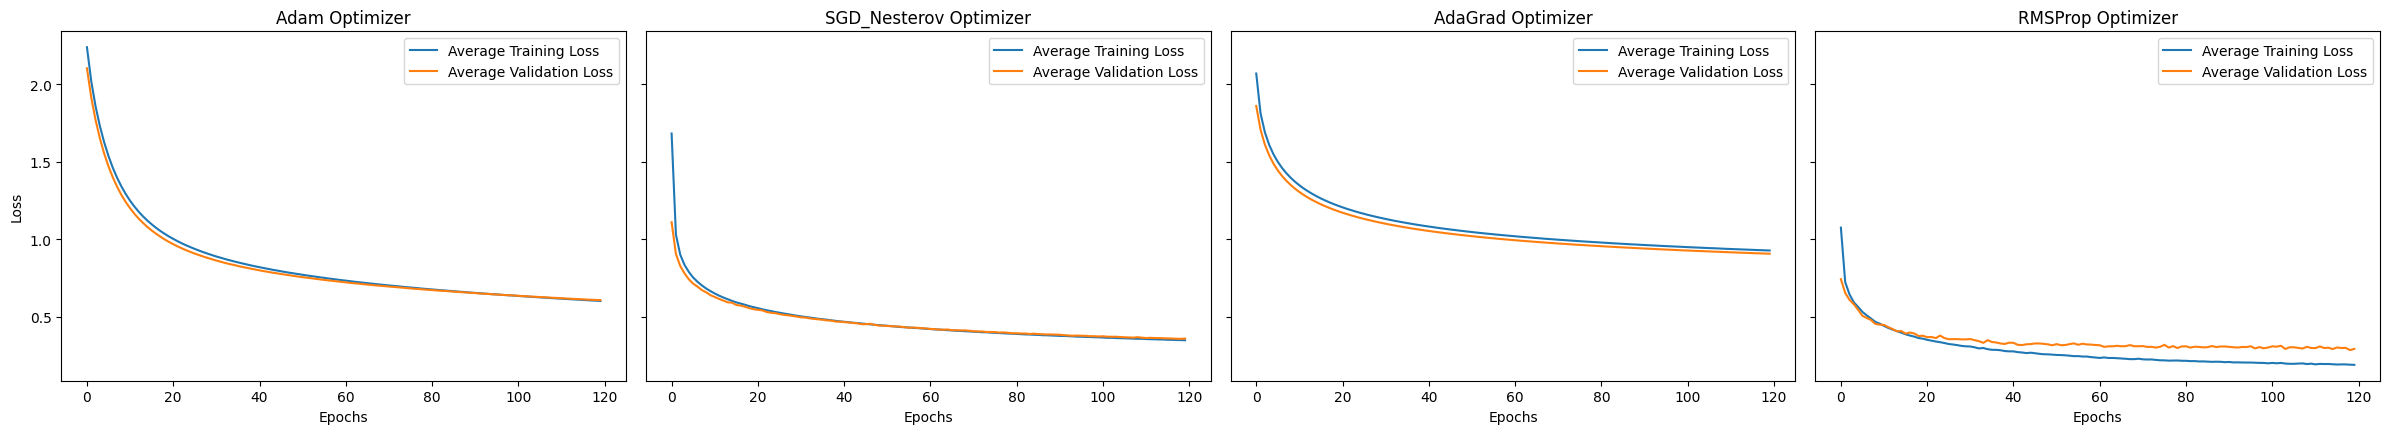

  0%|          | 0/4 [00:00<?, ?it/s]


Running grid search for Simple Neural Network with Adam
Fold 1, Accuracy: 93.55608591885442%
Fold 2, Accuracy: 93.79474940334129%
Fold 3, Accuracy: 94.49760765550239%
Fold 4, Accuracy: 96.88995215311004%
Fold 5, Accuracy: 93.0622009569378%
Params: {'lr': 0.001, 'betas': (0.9, 0.999)}, Accuracy: 94.36%
Fold 1, Accuracy: 94.27207637231504%
Fold 2, Accuracy: 93.79474940334129%
Fold 3, Accuracy: 93.30143540669856%
Fold 4, Accuracy: 95.2153110047847%
Fold 5, Accuracy: 94.49760765550239%
Params: {'lr': 0.001, 'betas': (0.95, 0.999)}, Accuracy: 94.22%
Fold 1, Accuracy: 93.55608591885442%
Fold 2, Accuracy: 93.31742243436754%
Fold 3, Accuracy: 94.49760765550239%
Fold 4, Accuracy: 95.45454545454545%
Fold 5, Accuracy: 93.77990430622009%
Params: {'lr': 0.001, 'betas': (0.85, 0.995)}, Accuracy: 94.12%
Fold 1, Accuracy: 92.8400954653938%
Fold 2, Accuracy: 94.27207637231504%
Fold 3, Accuracy: 92.58373205741627%
Fold 4, Accuracy: 95.2153110047847%
Fold 5, Accuracy: 93.77990430622009%
Params: {'lr': 0

 25%|██▌       | 1/4 [02:46<08:20, 166.78s/it]

Fold 10, Accuracy: 94.73684210526316%
Average Cross-Validation Accuracy: 94.5%

Running grid search for Simple Neural Network with SGD_Nesterov
Fold 1, Accuracy: 94.03341288782816%
Fold 2, Accuracy: 93.31742243436754%
Fold 3, Accuracy: 94.25837320574162%
Fold 4, Accuracy: 96.17224880382776%
Fold 5, Accuracy: 93.30143540669856%
Params: {'lr': 0.01, 'momentum': 0.95, 'nesterov': True}, Accuracy: 94.22%
Fold 1, Accuracy: 94.03341288782816%
Fold 2, Accuracy: 94.74940334128878%
Fold 3, Accuracy: 94.25837320574162%
Fold 4, Accuracy: 95.45454545454545%
Fold 5, Accuracy: 94.73684210526316%
Params: {'lr': 0.01, 'momentum': 0.9, 'nesterov': True}, Accuracy: 94.65%
Fold 1, Accuracy: 94.27207637231504%
Fold 2, Accuracy: 94.03341288782816%
Fold 3, Accuracy: 94.73684210526316%
Fold 4, Accuracy: 95.69377990430623%
Fold 5, Accuracy: 94.25837320574162%
Params: {'lr': 0.01, 'momentum': 0.8, 'nesterov': True}, Accuracy: 94.60%
Fold 1, Accuracy: 95.22673031026252%
Fold 2, Accuracy: 92.8400954653938%
Fold 

 50%|█████     | 2/4 [05:15<05:12, 156.31s/it]

Fold 10, Accuracy: 93.30143540669856%
Average Cross-Validation Accuracy: 94.93%

Running grid search for Simple Neural Network with AdaGrad
Fold 1, Accuracy: 88.78281622911695%
Fold 2, Accuracy: 89.97613365155131%
Fold 3, Accuracy: 89.23444976076556%
Fold 4, Accuracy: 93.54066985645933%
Fold 5, Accuracy: 92.10526315789474%
Params: {'lr': 0.01}, Accuracy: 90.73%
Fold 1, Accuracy: 83.29355608591885%
Fold 2, Accuracy: 86.63484486873509%
Fold 3, Accuracy: 83.49282296650718%
Fold 4, Accuracy: 87.32057416267942%
Fold 5, Accuracy: 87.08133971291866%
Params: {'lr': 0.005}, Accuracy: 85.56%
Fold 1, Accuracy: 64.67780429594272%
Fold 2, Accuracy: 63.72315035799522%
Fold 3, Accuracy: 62.67942583732057%
Fold 4, Accuracy: 63.63636363636363%
Fold 5, Accuracy: 61.004784688995215%
Params: {'lr': 0.001}, Accuracy: 63.14%
Fold 1, Accuracy: 46.062052505966584%
Fold 2, Accuracy: 46.062052505966584%
Fold 3, Accuracy: 49.282296650717704%
Fold 4, Accuracy: 44.97607655502392%
Fold 5, Accuracy: 53.8277511961722

 75%|███████▌  | 3/4 [06:22<01:55, 115.52s/it]

Fold 10, Accuracy: 89.95215311004785%
Average Cross-Validation Accuracy: 91.06%

Running grid search for Simple Neural Network with RMSProp
Fold 1, Accuracy: 92.12410501193317%
Fold 2, Accuracy: 86.15751789976133%
Fold 3, Accuracy: 93.54066985645933%
Fold 4, Accuracy: 85.88516746411483%
Fold 5, Accuracy: 88.27751196172248%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.95}, Accuracy: 89.20%
Fold 1, Accuracy: 90.45346062052506%
Fold 2, Accuracy: 91.64677804295943%
Fold 3, Accuracy: 91.38755980861244%
Fold 4, Accuracy: 93.54066985645933%
Fold 5, Accuracy: 94.25837320574162%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.9}, Accuracy: 92.26%
Fold 1, Accuracy: 91.40811455847255%
Fold 2, Accuracy: 91.40811455847255%
Fold 3, Accuracy: 88.27751196172248%
Fold 4, Accuracy: 94.73684210526316%
Fold 5, Accuracy: 93.0622009569378%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.8}, Accuracy: 91.78%
Fold 1, Accuracy: 92.36276849642005%
Fold 2, Accuracy: 90.69212410501193%
Fold 3, Accuracy: 

100%|██████████| 4/4 [10:08<00:00, 152.02s/it]

Fold 10, Accuracy: 95.69377990430623%
Average Cross-Validation Accuracy: 95.22%


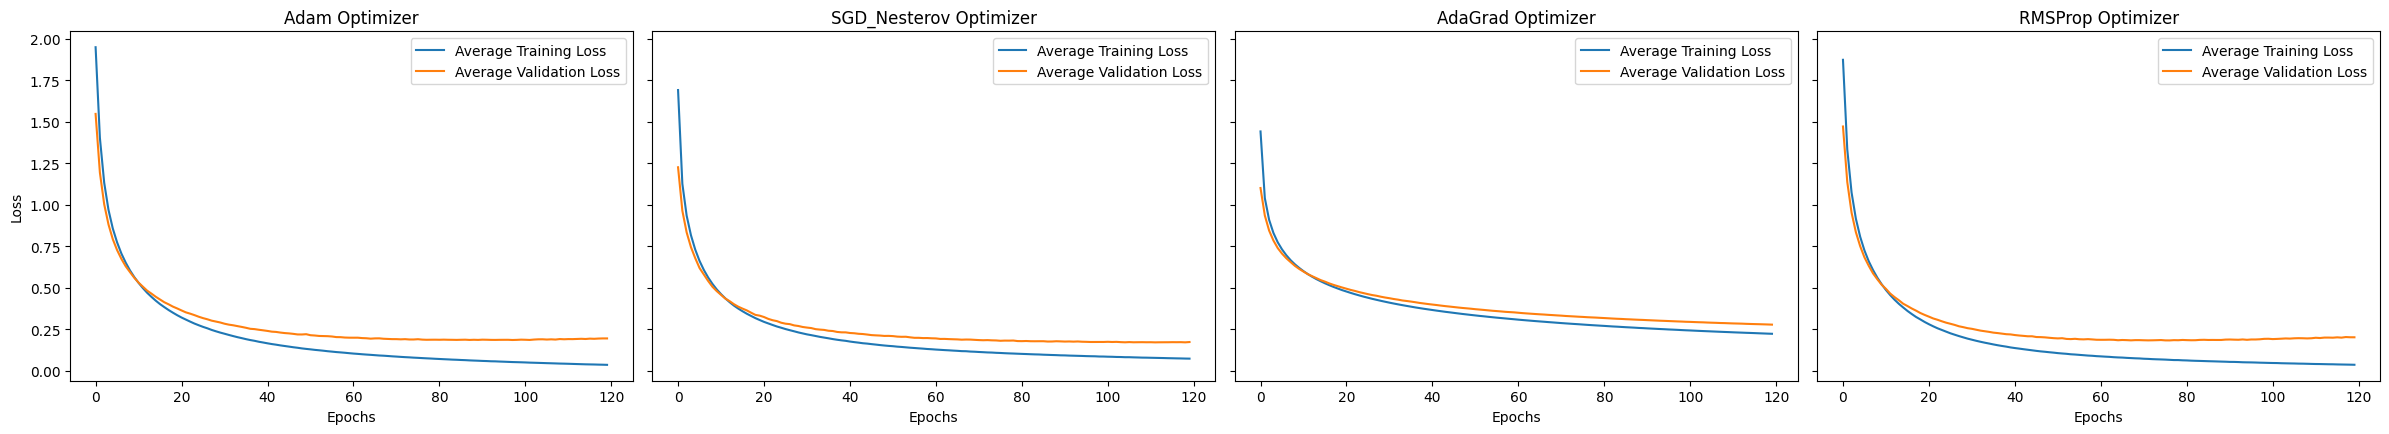

  0%|          | 0/4 [00:00<?, ?it/s]


Running grid search for Complex Neural Network with Adam
Fold 1, Accuracy: 94.03341288782816%
Fold 2, Accuracy: 95.22673031026252%
Fold 3, Accuracy: 94.25837320574162%
Fold 4, Accuracy: 96.88995215311004%
Fold 5, Accuracy: 96.65071770334929%
Params: {'lr': 0.001, 'betas': (0.9, 0.999)}, Accuracy: 95.41%
Fold 1, Accuracy: 93.79474940334129%
Fold 2, Accuracy: 94.98806682577566%
Fold 3, Accuracy: 93.0622009569378%
Fold 4, Accuracy: 96.41148325358851%
Fold 5, Accuracy: 94.49760765550239%
Params: {'lr': 0.001, 'betas': (0.95, 0.999)}, Accuracy: 94.55%
Fold 1, Accuracy: 94.27207637231504%
Fold 2, Accuracy: 94.5107398568019%
Fold 3, Accuracy: 95.69377990430623%
Fold 4, Accuracy: 97.36842105263158%
Fold 5, Accuracy: 96.17224880382776%
Params: {'lr': 0.001, 'betas': (0.85, 0.995)}, Accuracy: 95.60%
Fold 1, Accuracy: 92.8400954653938%
Fold 2, Accuracy: 93.31742243436754%
Fold 3, Accuracy: 94.97607655502392%
Fold 4, Accuracy: 95.69377990430623%
Fold 5, Accuracy: 93.54066985645933%
Params: {'lr':

 25%|██▌       | 1/4 [04:16<12:50, 256.84s/it]

Fold 10, Accuracy: 97.12918660287082%
Average Cross-Validation Accuracy: 95.89%

Running grid search for Complex Neural Network with SGD_Nesterov
Fold 1, Accuracy: 89.26014319809069%
Fold 2, Accuracy: 93.79474940334129%
Fold 3, Accuracy: 93.77990430622009%
Fold 4, Accuracy: 94.73684210526316%
Fold 5, Accuracy: 94.49760765550239%
Params: {'lr': 0.01, 'momentum': 0.95, 'nesterov': True}, Accuracy: 93.21%
Fold 1, Accuracy: 90.69212410501193%
Fold 2, Accuracy: 93.55608591885442%
Fold 3, Accuracy: 94.25837320574162%
Fold 4, Accuracy: 96.88995215311004%
Fold 5, Accuracy: 95.2153110047847%
Params: {'lr': 0.01, 'momentum': 0.9, 'nesterov': True}, Accuracy: 94.12%
Fold 1, Accuracy: 85.91885441527447%
Fold 2, Accuracy: 94.27207637231504%
Fold 3, Accuracy: 95.2153110047847%
Fold 4, Accuracy: 96.41148325358851%
Fold 5, Accuracy: 94.73684210526316%
Params: {'lr': 0.01, 'momentum': 0.8, 'nesterov': True}, Accuracy: 93.31%
Fold 1, Accuracy: 93.79474940334129%
Fold 2, Accuracy: 93.79474940334129%
Fold

 50%|█████     | 2/4 [07:46<07:38, 229.22s/it]

Fold 10, Accuracy: 89.47368421052632%
Average Cross-Validation Accuracy: 94.55%

Running grid search for Complex Neural Network with AdaGrad
Fold 1, Accuracy: 87.58949880668258%
Fold 2, Accuracy: 85.91885441527447%
Fold 3, Accuracy: 89.47368421052632%
Fold 4, Accuracy: 90.19138755980862%
Fold 5, Accuracy: 90.9090909090909%
Params: {'lr': 0.01}, Accuracy: 88.82%
Fold 1, Accuracy: 80.1909307875895%
Fold 2, Accuracy: 80.90692124105011%
Fold 3, Accuracy: 79.42583732057416%
Fold 4, Accuracy: 79.90430622009569%
Fold 5, Accuracy: 83.01435406698565%
Params: {'lr': 0.005}, Accuracy: 80.69%
Fold 1, Accuracy: 52.74463007159905%
Fold 2, Accuracy: 57.04057279236277%
Fold 3, Accuracy: 49.760765550239235%
Fold 4, Accuracy: 50.95693779904306%
Fold 5, Accuracy: 56.698564593301434%
Params: {'lr': 0.001}, Accuracy: 53.44%
Fold 1, Accuracy: 49.88066825775656%
Fold 2, Accuracy: 32.93556085918854%
Fold 3, Accuracy: 47.36842105263158%
Fold 4, Accuracy: 42.58373205741627%
Fold 5, Accuracy: 49.760765550239235%

 75%|███████▌  | 3/4 [09:28<02:50, 170.88s/it]

Fold 10, Accuracy: 90.43062200956938%
Average Cross-Validation Accuracy: 89.44%

Running grid search for Complex Neural Network with RMSProp
Fold 1, Accuracy: 15.035799522673031%
Fold 2, Accuracy: 13.842482100238664%
Fold 3, Accuracy: 14.114832535885167%
Fold 4, Accuracy: 16.74641148325359%
Fold 5, Accuracy: 16.267942583732058%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.95}, Accuracy: 15.20%
Fold 1, Accuracy: 15.035799522673031%
Fold 2, Accuracy: 13.842482100238664%
Fold 3, Accuracy: 18.660287081339714%
Fold 4, Accuracy: 11.004784688995215%
Fold 5, Accuracy: 13.157894736842104%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.9}, Accuracy: 14.34%
Fold 1, Accuracy: 12.171837708830548%
Fold 2, Accuracy: 45.10739856801909%
Fold 3, Accuracy: 14.114832535885167%
Fold 4, Accuracy: 14.832535885167465%
Fold 5, Accuracy: 16.74641148325359%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.8}, Accuracy: 20.59%
Fold 1, Accuracy: 15.75178997613365%
Fold 2, Accuracy: 16.2291169451074%
Fold 

100%|██████████| 4/4 [15:04<00:00, 226.03s/it]

Fold 10, Accuracy: 95.2153110047847%
Average Cross-Validation Accuracy: 95.27%


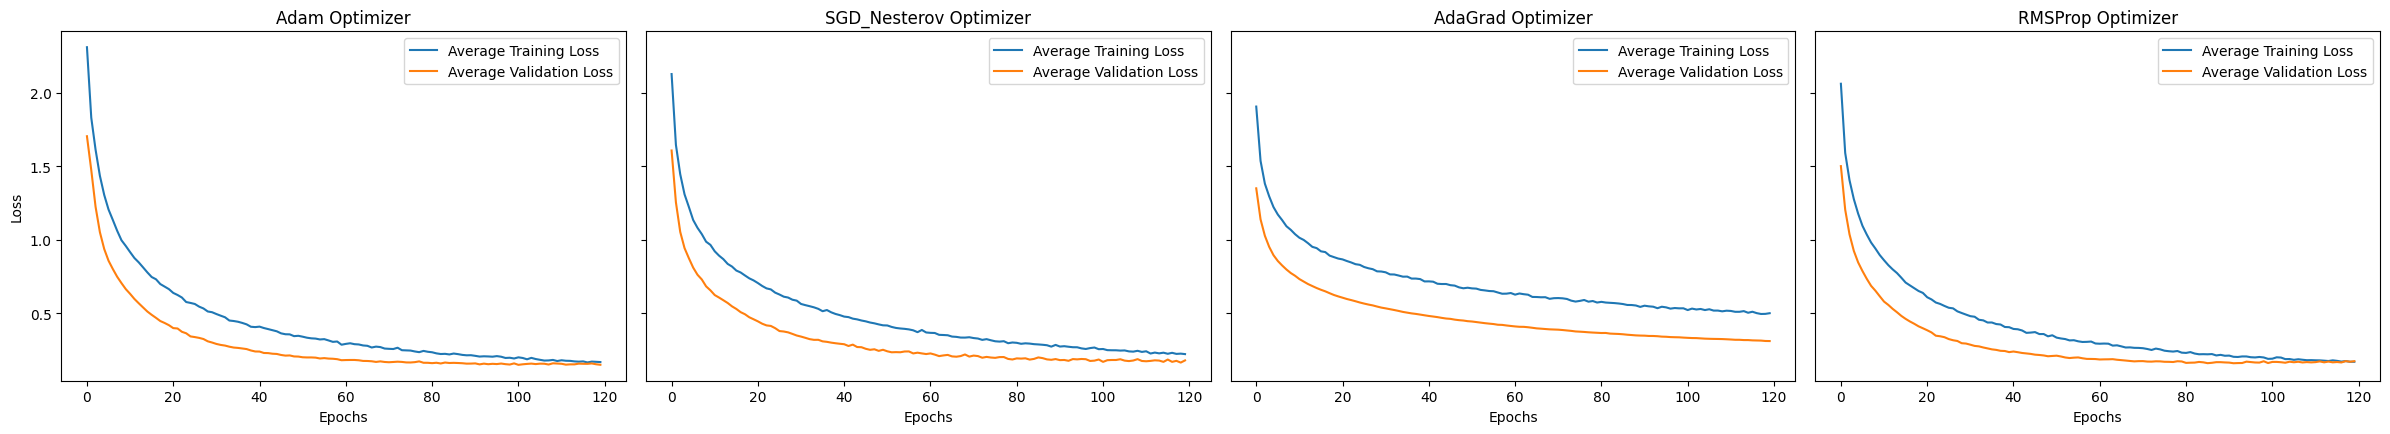

In [31]:
all_avg_accuracies = {}
all_best_params = {}

for model_name, model_factory in models.items():
    optimizer_losses = {}
    avg_accuracies = {}
    best_params = {}
    for opt_name, (opt_factory, opt_grid) in tqdm(optimizers.items()):
        print(f"\nRunning grid search for {model_name} with {opt_name}")
        
        best_params_opti, best_accuracy = grid_search_optimizer(
            model_factory, opt_factory, opt_grid, X_filtered, y_filtered, k_folds=5, epochs=120
        )
        print(f"Best parameters for {model_name} using {opt_name}: {best_params_opti}, Best Accuracy: {best_accuracy}%")

        optimized_optimizer_factory = lambda model: opt_factory(model, **best_params_opti)
        print(f"\nTraining {model_name} with {opt_name} using best parameters")
        avg_accuracy, all_train_losses, all_val_losses = perform_cross_validation(
            model_factory, optimized_optimizer_factory, X_filtered, y_filtered, k_folds=10, epochs=120
        )

        optimizer_losses[opt_name] = (all_train_losses, all_val_losses)
        avg_accuracies[opt_name] = avg_accuracy
        best_params[opt_name] = best_params_opti
        
        print(f'Average Cross-Validation Accuracy: {round(avg_accuracy, 2)}%')  
    all_avg_accuracies[model_name] = avg_accuracies
    all_best_params[model_name] = best_params

In [32]:
all_avg_accuracies

{'Logistic Regression': {'Adam': 78.63203463203463,
  'SGD_Nesterov': 89.05536568694465,
  'AdaGrad': 65.82114376851219,
  'RMSProp': 93.69218500797449},
 'Simple Neural Network': {'Adam': 94.50375939849623,
  'SGD_Nesterov': 94.93392572339941,
  'AdaGrad': 91.06311232627021,
  'RMSProp': 95.22055137844612},
 'Complex Neural Network': {'Adam': 95.89040783777627,
  'SGD_Nesterov': 94.55115060378219,
  'AdaGrad': 89.43722943722943,
  'RMSProp': 95.26771474139895}}

In [15]:
all_best_params

{'Logistic Regression': {'Adam': {'lr': 0.001, 'betas': (0.85, 0.995)},
  'SGD_Nesterov': {'lr': 0.01, 'momentum': 0.95, 'nesterov': True},
  'AdaGrad': {'lr': 0.01},
  'RMSProp': {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.8}},
 'Simple Neural Network': {'Adam': {'lr': 0.001, 'betas': (0.9, 0.999)},
  'SGD_Nesterov': {'lr': 0.005, 'momentum': 0.9, 'nesterov': True},
  'AdaGrad': {'lr': 0.01},
  'RMSProp': {'lr': 0.0001, 'alpha': 0.9, 'momentum': 0.9}},
 'Complex Neural Network': {'Adam': {'lr': 0.001, 'betas': (0.85, 0.995)},
  'SGD_Nesterov': {'lr': 0.005, 'momentum': 0.9, 'nesterov': True},
  'AdaGrad': {'lr': 0.01},
  'RMSProp': {'lr': 0.0001, 'alpha': 0.99, 'momentum': 0.9}}}

## Training with best hyper-paramters

After getting the best hyper-parameters for each model and optimizers, when can now compare, for a given model, the performance of each optimizers. This performance is related to the convergence speed. So, let's train each model on the full dataset, and plot the evolution of the loss functions, for $T=120$ epochs:

In [22]:
import torch

Logistic Regression Adam
Logistic Regression SGD_Nesterov
Logistic Regression AdaGrad
Logistic Regression RMSProp
Simple Neural Network Adam
Simple Neural Network SGD_Nesterov
Simple Neural Network AdaGrad
Simple Neural Network RMSProp
Complex Neural Network Adam
Complex Neural Network SGD_Nesterov
Complex Neural Network AdaGrad
Complex Neural Network RMSProp


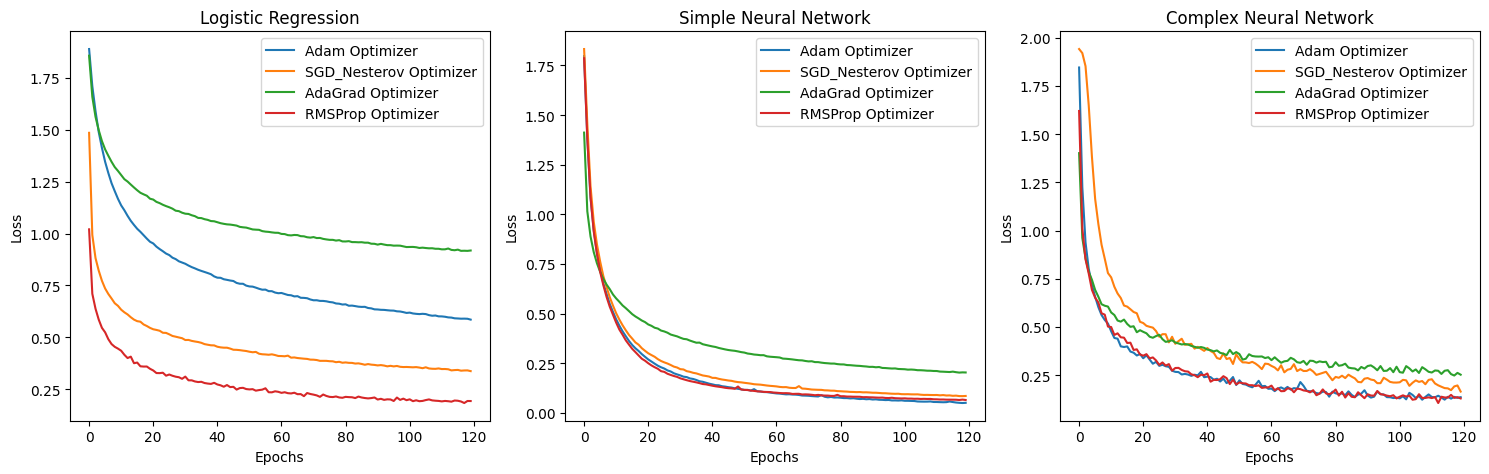

In [17]:
X_preprocessed, y_preprocessed = preprocess_data(X_filtered), pd.get_dummies(y_filtered).values

models_losses = {}
for model_name, model_factory in models.items():
    optimizers_losses = {}
    for opt_name, (opt_factory, _) in optimizers.items():
        print(model_name, opt_name)
        model = model_factory(X_preprocessed.shape[1], y_preprocessed.shape[1])
        optimizer = opt_factory(model, **all_best_params[model_name][opt_name])
        X_tensor, y_tensor = torch.tensor(X_preprocessed, dtype=torch.float32), torch.tensor(y_preprocessed, dtype=torch.float32)
        losses = train_full_dataset(model, optimizer, X_tensor, y_tensor, epochs=120)
        optimizers_losses[opt_name] = losses
    models_losses[model_name] = optimizers_losses

plot_optimizer_losses_for_models(models_losses, save=True)